# import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# Instantiate
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition

import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

import string
import itertools

nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

from nltk import pos_tag, ne_chunk

import warnings

warnings.filterwarnings('ignore')



# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


In [2]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df = pd.read_csv('ted_talks_en_10000.csv')

In [6]:
df.head(2)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."


In [7]:
df.isnull().values.any()

True

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   talk_id         998 non-null    int64 
 1   title           998 non-null    object
 2   speaker_1       998 non-null    object
 3   all_speakers    998 non-null    object
 4   occupations     998 non-null    object
 5   about_speakers  998 non-null    object
 6   views           998 non-null    int64 
 7   recorded_date   998 non-null    object
 8   published_date  998 non-null    object
 9   event           998 non-null    object
 10  native_lang     998 non-null    object
 11  available_lang  998 non-null    object
 12  comments        998 non-null    int64 
 13  duration        998 non-null    int64 
 14  topics          998 non-null    object
 15  related_talks   998 non-null    object
 16  url             998 non-null    object
 17  description     998 non-null    object
 18  transcript

# EDA

In [11]:
pop_talks = df[['title', 'speaker_1', 'views', 'published_date']].sort_values('views', ascending=False)[:15]
pop_talks

,title,speaker_1,views,published_date
4,Do schools kill creativity?,Sir Ken Robinson,65051954,2006-06-27
646,How great leaders inspire action,Simon Sinek,49730580,2010-05-04
796,The power of vulnerability,Brené Brown,47544833,2010-12-23
443,10 things you didn't know about orgasm,Mary Roach,30977634,2009-05-20
990,How to spot a liar,Pamela Meyer,28748868,2011-10-13
197,My stroke of insight,Jill Bolte Taylor,26553231,2008-03-12
490,The puzzle of motivation,Dan Pink,25654121,2009-08-24
578,How I held my breath for 17 minutes,David Blaine,25395829,2010-01-19
519,The danger of a single story,Chimamanda Ngozi Adichie,21858495,2009-10-07
374,Your elusive creative genius,Elizabeth Gilbert,19256266,2009-02-09


In [12]:
pop_talks['abbr'] = pop_talks['speaker_1'].apply(lambda x: x[:3])
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sb.barplot(x='abbr', y='views', data=pop_talks)

NameError: name 'sns' is not defined

# TopicModelling

In [13]:
df.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript'],
      dtype='object')

In [14]:
TED=df[['title','transcript' ]]

In [15]:
pd.set_option('display.max_colwidth',-1)
TED

title  \
0    Averting the climate crisis                
1    The best stats you've ever seen            
2    Simplicity sells                           
3    Greening the ghetto                        
4    Do schools kill creativity?                
..                           ...                
995  A prosthetic arm that "feels"              
996  Art made of storms                         
997  How economic inequality harms societies    
998  The strange tale of the Norden bombsight   
999  Open-source cancer research                

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [16]:
X_train, X_test = train_test_split(TED, test_size=0.3, random_state=111)

In [17]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# This function will tokenize the words, convert to lower case and do the stemming
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

## Feature_extraction

In [19]:
# Instatiate
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
# Fit & Transform
tfidf_vectors = vectorizer.fit_transform(X_train.transcript)

In [20]:
tfidf_vectors.shape # THE TERM DOCUMENT MATRIX (MATRIX ON THE LEFT HAND SIDE)

(698, 1000)

In [21]:
tfidf_vectors.A

array([[0.        , 0.07098442, 0.03394553, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02849274, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01998329, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01116509, 0.        , ..., 0.        , 0.04621868,
        0.02077778],
       [0.        , 0.01579058, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
vectorizer.get_feature_names()

['abil',
 'abl',
 'absolut',
 'accept',
 'access',
 'account',
 'achiev',
 'action',
 'activ',
 'adapt',
 'address',
 'adult',
 'advanc',
 'affect',
 'afford',
 'africa',
 'african',
 'age',
 'agre',
 'agricultur',
 'ahead',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'amaz',
 'america',
 'american',
 'anim',
 'anoth',
 'answer',
 'anybodi',
 'anymor',
 'anyon',
 'anyth',
 'anywher',
 'apart',
 'appear',
 'applaus thank',
 'appli',
 'approach',
 'architectur',
 'area',
 'arriv',
 'artist',
 'ask',
 'atmospher',
 'atom',
 'attack',
 'attent',
 'audienc',
 'author',
 'avail',
 'averag',
 'awar',
 'away',
 'babi',
 'bacteria',
 'balanc',
 'bank',
 'base',
 'basic',
 'beauti',
 'becam',
 'becom',
 'began',
 'begin',
 'behavior',
 'believ',
 'benefit',
 'best',
 'better',
 'bigger',
 'biggest',
 'billion',
 'biolog',
 'bird',
 'black',
 'blind',
 'block',
 'blog',
 'blood',
 'blue',
 'board',
 'bodi',
 'bomb',
 'bone',
 'book',
 'born',
 'bought',
 'brain',
 'bread',
 'break',
 'brea

In [23]:
len(vectorizer.get_feature_names())

1000

# 1-DECOMPOSITION USING LSA

In [24]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
# Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
# Instantiate lsa
lsa = TruncatedSVD(4)
# Fit & Transform
doc_topic = lsa.fit_transform(tfidf_vectors)

In [25]:
print (doc_topic)

[[ 0.29851726 -0.18576682 -0.02425402  0.15117189]
 [ 0.3000172   0.35478491 -0.30460609 -0.20122034]
 [ 0.34750301 -0.08846074 -0.24983757  0.09000038]
 ...
 [ 0.13638279  0.14337562 -0.17499084 -0.09356197]
 [ 0.42253937  0.19257156  0.01443514  0.01321494]
 [ 0.27659628 -0.05518372  0.06515261 -0.06532629]]


In [26]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
display_topics(lsa, vectorizer.get_feature_names(), 5)


Topic  0
said, kind, littl, life, happen

Topic  1
music, said, women, school, stori

Topic  2
africa, countri, govern, percent, women

Topic  3
brain, cell, patient, comput, inform


# 2-DECOMPOSITION USING LDA

In [28]:
def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2) ] 
   stems = [stemmer.stem(item) for item in tokens]
   return tokens

In [29]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_df=0.75, min_df=50, max_features=10000, use_idf=False, norm=None)
tf_vectors = vectorizer_tf.fit_transform(X_train.transcript)

In [30]:
tf_vectors.A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
vectorizer_tf.get_feature_names()

['1,000',
 '10,000',
 'ability',
 'able',
 'absolute',
 'absolutely',
 'access',
 'according',
 'achieve',
 'action',
 'active',
 'activity',
 'actual',
 'address',
 'advantage',
 'affect',
 'afford',
 'afraid',
 'africa',
 'african',
 'agree',
 'ahead',
 'alive',
 'allow',
 'allowed',
 'allows',
 'amazing',
 'america',
 'american',
 'americans',
 'ancient',
 'anderson',
 'animal',
 'animals',
 'answer',
 'answers',
 'anybody',
 'anymore',
 'apart',
 'appear',
 'apply',
 'approach',
 'architecture',
 'area',
 'areas',
 'argue',
 'arrived',
 'article',
 'artist',
 'asia',
 'asked',
 'asking',
 'atmosphere',
 'attention',
 'audience',
 'available',
 'average',
 'avoid',
 'aware',
 'away',
 'awful',
 'baby',
 'background',
 'balance',
 'bank',
 'base',
 'based',
 'basic',
 'basically',
 'basis',
 'beat',
 'beautiful',
 'beauty',
 'began',
 'begin',
 'beginning',
 'begins',
 'behavior',
 'beings',
 'believe',
 'believed',
 'benefit',
 'benefits',
 'best',
 'better',
 'bigger',
 'biggest',


In [32]:
# Instantiate LDA
lda = decomposition.LatentDirichletAllocation(n_components=6, max_iter=3, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [33]:
W1.shape

(698, 6)

# 3-DECOMPOSITION USING NMF

In [34]:

# INSTANTIATE. n_components is the number of TOPICS
clf = decomposition.NMF(n_components=4, random_state=111) # components is the number of topics

W1 = clf.fit_transform(tfidf_vectors) # matrix
H1 = clf.components_ #componets

In [35]:
# NMF Decomposition
# tfidf_vectors =  W1 x H1

In [36]:
tfidf_vectors.shape

(698, 1000)

In [37]:
W1.shape

(698, 4)

In [38]:
W1

array([[0.03233351, 0.        , 0.02754615, 0.17486864],
       [0.        , 0.23769052, 0.        , 0.        ],
       [0.06932539, 0.02896878, 0.        , 0.17417498],
       ...,
       [0.00537548, 0.11278195, 0.        , 0.        ],
       [0.        , 0.19932196, 0.05959631, 0.03876111],
       [0.07744699, 0.04535738, 0.07403586, 0.00038233]])

In [39]:
H1.shape

(4, 1000)

In [40]:
H1 # TOPICS - TERMS MATRIX

array([[0.00644722, 0.08668262, 0.02914818, ..., 0.03542154, 0.00779208,
        0.04171085],
       [0.01221702, 0.03962077, 0.05579603, ..., 0.0712681 , 0.11697445,
        0.00475725],
       [0.03649283, 0.05025722, 0.04313502, ..., 0.01597731, 0.04765824,
        0.02848933],
       [0.06701983, 0.12601365, 0.01479899, ..., 0.038122  , 0.        ,
        0.03013157]])

In [41]:
H1[:, 0:1]

array([[0.00644722],
       [0.01221702],
       [0.03649283],
       [0.06701983]])

In [42]:
num_words=30 # TOPIC IS DEFINED AS A COLLECTION OF 30 WORDS

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [43]:
topics # The top 20  words in the 6 topics
#1- geology.
#2- stories
#3 economy 
#4 computer science

['water planet earth ocean citi energi build life light plant anim space tree speci natur univers live materi surfac fish place star mile littl human land billion galaxi bacteria bird',
 'said music love stori feel tell life say went littl play school mother film good thought women children girl woman live mean kid compass book alway believ father walk happi',
 'countri africa percent dollar govern market state problem chang food money health unit busi african global million compani develop econom economi china societi school educ mani invest unit state communiti women',
 'brain comput design technolog kind cell inform data differ idea use littl sort exampl devic patient human creat project problem object pattern video imag visual real robot interact abl build']

In [53]:
model_names={}
def display_topics_names(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        value = ", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        model_names[f'topic {ix}'] = value
    return model_names

In [73]:
new_key = ["Geology" , "stories", "Economy", "Computer Scince" ] 
#old_key = ['topic 0', 'topic 1','topic 2','topic 3','topic 4','topic 5','topic 6','topic 7','topic 8','topic 9','topic 10','topic 11','topic 12','topic 13','topic 14','topic 15','topic 16','topic 17','topic 18','topic 19','topic 20','topic 21','topic 22','topic 23','topic 24']

final_dict = dict(zip(new_key, list(model_names.values())))
final_dict

{'Geology': 'water, planet, earth, ocean, citi',
 'stories': 'said, music, love, stori, feel',
 'Economy': 'countri, africa, percent, dollar, govern',
 'Computer Scince': 'brain, comput, design, technolog, kind'}

In [74]:
columns_names = [ 'Topic_words']

In [75]:
Topic_final = pd.DataFrame.from_dict(final_dict, orient='index')
Topic_final

,0
Geology,"water, planet, earth, ocean, citi"
stories,"said, music, love, stori, feel"
Economy,"countri, africa, percent, dollar, govern"
Computer Scince,"brain, comput, design, technolog, kind"


In [76]:
colnames = new_key #["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.transcript))]
TED_DATA = pd.DataFrame(np.round(W1, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(TED_DATA.values, axis=1)
TED_DATA ['dominant_topic'] = significant_topic

In [77]:
TED_DATA 

,Geology,stories,Economy,Computer Scince,dominant_topic
Doc0,0.032,0.000,0.028,0.175,3
Doc1,0.000,0.238,0.000,0.000,1
Doc2,0.069,0.029,0.000,0.174,3
Doc3,0.004,0.000,0.116,0.056,2
Doc4,0.137,0.041,0.028,0.006,0
...,...,...,...,...,...
Doc693,0.000,0.093,0.000,0.151,3
Doc694,0.072,0.186,0.000,0.051,1
Doc695,0.005,0.113,0.000,0.000,1
Doc696,0.000,0.199,0.060,0.039,1


In [78]:
display_topics_names(clf,vectorizer.get_feature_names(), 5)

{'topic 0': 'water, planet, earth, ocean, citi',
 'topic 1': 'said, music, love, stori, feel',
 'topic 2': 'countri, africa, percent, dollar, govern',
 'topic 3': 'brain, comput, design, technolog, kind'}

In [69]:
X_train.head(3)

title  \
659  Watch me unveil "synthetic life"    
371  Fiddling in reel time               
520  Optical illusions show how we see   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [70]:
# We now test the model on the test set
Wtest = clf.transform(vectorizer.transform(X_test.transcript[:1000]))

In [71]:
Wtest.shape

(300, 4)

In [72]:
colnames =new_key  #["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_test[:1000].transcript))]
TED_DATA = pd.DataFrame(np.round(Wtest, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(TED_DATA.values, axis=1)
TED_DATA ['dominant_topic'] = significant_topic

In [177]:
TED_DATA # we check manloly

,Geology,stories,Economy,Computer Scince,dominant_topic
Doc0,0.020,0.153,0.000,0.032,1
Doc1,0.000,0.032,0.000,0.264,3
Doc2,0.000,0.015,0.000,0.107,3
Doc3,0.007,0.123,0.160,0.091,2
Doc4,0.000,0.154,0.000,0.046,1
...,...,...,...,...,...
Doc295,0.000,0.078,0.000,0.236,3
Doc296,0.035,0.013,0.156,0.112,2
Doc297,0.027,0.026,0.044,0.127,3
Doc298,0.115,0.018,0.200,0.000,2


In [178]:
#" Juggle and jest"   belong to stories 
# " How brain science will change computing"  belong to Computer Scince
#" Robots will invade our lives"   belong to Computer Scince
# "One Laptop per Child"  belong to Economy
# "How to truly listen"  belong to stories

In [179]:
X_test.head(6)

title  \
190  Juggle and jest                           
104  How brain science will change computing   
295  Robots will invade our lives              
12   One Laptop per Child                      
87   How to truly listen                       
523  Robots that "show emotion"                

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

# Clusting

In [81]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(TED_DATA )
Scaled_data=scaler.transform(TED_DATA )

In [82]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[2],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

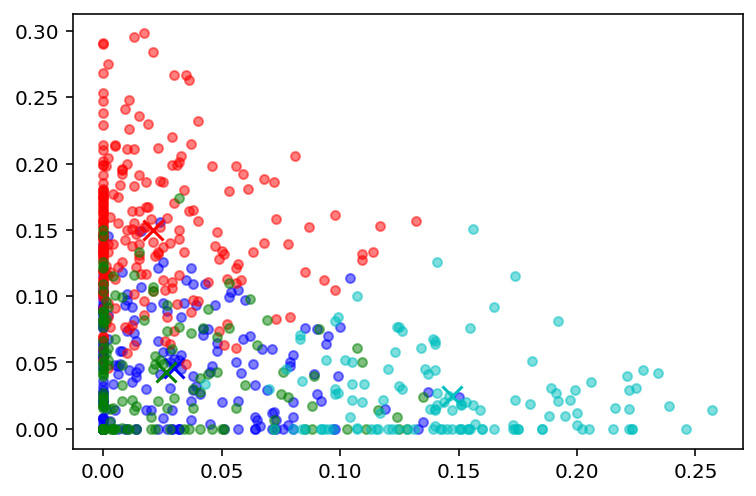

In [88]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1)
km.fit(TED_DATA )
display_cluster(TED_DATA .values,km,num_clusters)

In [180]:
TED_DATA

,Geology,stories,Economy,Computer Scince,dominant_topic
Doc0,0.020,0.153,0.000,0.032,1
Doc1,0.000,0.032,0.000,0.264,3
Doc2,0.000,0.015,0.000,0.107,3
Doc3,0.007,0.123,0.160,0.091,2
Doc4,0.000,0.154,0.000,0.046,1
...,...,...,...,...,...
Doc295,0.000,0.078,0.000,0.236,3
Doc296,0.035,0.013,0.156,0.112,2
Doc297,0.027,0.026,0.044,0.127,3
Doc298,0.115,0.018,0.200,0.000,2


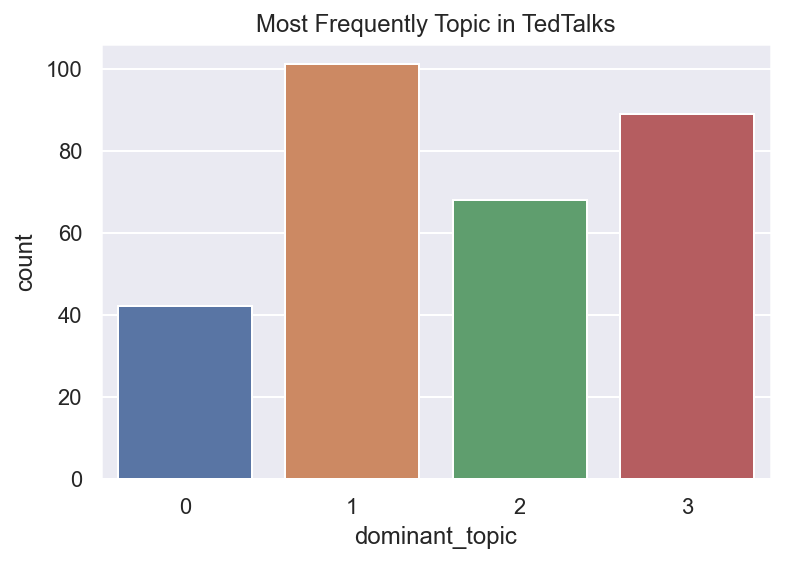

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [187]:
sb.countplot(TED_DATA["dominant_topic"])
plt.title("Most Frequently Topic in TedTalks")
plt.show()
plt

In [119]:
new_key

['Geology', 'stories', 'Economy', 'Computer Scince']